In [2]:
%load_ext autoreload
%autoreload 1
%aimport ecg_get_data
%aimport Models
%aimport train_test_validat
%aimport self_attention
%aimport ecg_plot
%aimport Net
%aimport select_dataset
%aimport relat_abs_Net
import relat_abs_Net
import select_dataset
import Models 
from tqdm import tqdm
import Net
from train_test_validat import *
from self_attention import *
import  ecg_get_data 
import matplotlib.pyplot as plt
import ecg_plot

import torch
import torch.utils.data as Data
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import random
import pandas as pd

import time
import os
import gc

random_seed = 2
torch.manual_seed(random_seed)    # reproducible
torch.cuda.manual_seed_all(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)

time_str = time.strftime("%Y%m%d_%H%M%S", time.localtime()) 

In [6]:
model_path = './model/'+time_str
log_path = './log/'+  time_str
ECG_root = '/workspace/data/Preprocess_HTN/data/ECG'
EcgChannles_num = 12
EcgLength_num = 5000
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda:0


In [ ]:
data = select_dataset.splite_dataset('/workspace/data/Preprocess_HTN/data/',True)
test_list = data.__get_test_file_list__(False)
# print(valid_list)
valid_list,train_list,addition_train_list = data.__get_VT_file_list__(0,False)


In [ ]:
test_infos_df = data.__read_infos__(test_list)
test_infos_df = test_infos_df.dropna(subset=['years']) #删除years== nan
test_infos_df.loc[~(test_infos_df['years'].str.contains('岁')),'years']='0岁' #不含有岁的（天周月）改为"0岁"
test_infos_df['years'].replace(regex=True,inplace=True,to_replace=r'岁',value=r'') #删除"岁"
test_infos_df['gender'].replace(regex=True,inplace=True,to_replace=r'男',value=r'1') #替换男
test_infos_df['gender'].replace(regex=True,inplace=True,to_replace=r'女',value=r'0') #替换男

train_infos_df = data.__read_infos__(train_list)
train_infos_df = train_infos_df.dropna(subset=['years']) #删除years== nan
train_infos_df.loc[~(train_infos_df['years'].str.contains('岁')),'years']='0岁' #不含有岁的（天周月）改为"0岁"
train_infos_df['years'].replace(regex=True,inplace=True,to_replace=r'岁',value=r'') #删除"岁"
train_infos_df['gender'].replace(regex=True,inplace=True,to_replace=r'男',value=r'1') #替换男
train_infos_df['gender'].replace(regex=True,inplace=True,to_replace=r'女',value=r'0') #替换男


In [ ]:
plt.figure(figsize=(10,5))
plt.subplot2grid((1,2),(0,0))
(pd.to_numeric(test_infos_df.years[test_infos_df['ECG_path'].str.contains('_HTN')])).plot(kind = 'kde')
(pd.to_numeric(test_infos_df.years[test_infos_df['ECG_path'].str.contains('_NHTN')])).plot(kind = 'kde')


In [ ]:
test_infos_df.gender[test_infos_df['ECG_path'].str.contains('_HTN')].value_counts().plot.pie(autopct = '%1.2f%%')

In [ ]:
test_infos_df.gender[test_infos_df['ECG_path'].str.contains('_NHTN')].value_counts().plot.pie(autopct = '%1.2f%%') 

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot2grid((1,2),(0,0))
(pd.to_numeric(train_infos_df.years[train_infos_df['ECG_path'].str.contains('_HTN')])).plot(kind = 'kde')
(pd.to_numeric(train_infos_df.years[train_infos_df['ECG_path'].str.contains('_NHTN')])).plot(kind = 'kde')

In [ ]:
train_infos_df.gender[train_infos_df['ECG_path'].str.contains('_HTN')].value_counts().plot.pie(autopct = '%1.2f%%')

In [ ]:
train_infos_df.gender[train_infos_df['ECG_path'].str.contains('_NHTN')].value_counts().plot.pie(autopct = '%1.2f%%')

In [ ]:
import math
for fold in range(FOLDS):
    #每个人fold都重新抽取
    NET[fold].to(DEVICE)
    valid_list,train_list,addition_train_list = data.__get_VT_file_list__(0.2,True)
    valid_Dataset = ecg_get_data.ECG_Dataset(ECG_root,valid_list,EcgChannles_num,EcgLength_num)
    train_Dataset = ecg_get_data.ECG_Dataset(ECG_root,train_list,EcgChannles_num,EcgLength_num,ECG_root,addition_train_list)
    
    train_dataloader = Data.DataLoader(dataset=train_Dataset, batch_size=BATCH_SIZE, shuffle=True,num_workers=16,pin_memory=True)
    valid_dataloader = Data.DataLoader(dataset=valid_Dataset, batch_size=BATCH_SIZE, shuffle=True,num_workers=16,pin_memory=True)
    #test_dataloader = Data.DataLoader(dataset=test_Dataset, batch_size=25, shuffle=True,num_workers=1,pin_memory=True)
    early_stopping = EarlyStopping(PATIENCE, verbose=True, model_path=model_path, delta=0, positive=False)
    optimizer  = torch.optim.Adam(NET[fold].parameters(), lr=LR,weight_decay=1e-2)  
    
    warm_up_iter = 6
    T_max = 16	# 周期
    lr_max = 1e-3	# 最大值
    lr_min = 1e-5	# 最小值
    lambda0 = lambda cur_iter: (cur_iter / warm_up_iter)*lr_max if  cur_iter < warm_up_iter else \
        (lr_min + 0.5*(lr_max-lr_min)*(1.0+math.cos( (cur_iter-warm_up_iter)/(T_max-warm_up_iter)*math.pi)))/0.1
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda0)
    criterion = torch.nn.CrossEntropyLoss()   

    for epoch in range(1,EPOCHS):
        time_all=0
        start_time = time.time()
        y_true,y_pred,train_loss,train_acc = train_model(train_dataloader, NET[fold], criterion, optimizer,DEVICE) # type: ignore # 训练模型
        time_all = time.time()-start_time
        C0 = confusion_matrix(y_true,y_pred)
        F1_score_train =f1_score(y_true, y_pred, average='macro')#F1分数
        y_true,y_pred,validate_loss,validate_acc = eval_model(valid_dataloader,criterion,NET[fold],DEVICE) # 验证模型
        F1_score_valid =f1_score(y_true, y_pred, average='macro')#F1分数
        writer.add_scalars(main_tag=str(fold)+'_Loss',tag_scalar_dict={'train': train_loss,'validate': validate_loss},global_step=epoch)
        writer.add_scalars(main_tag=str(fold)+'_Accuracy',tag_scalar_dict={'train': train_acc,'validate': validate_acc},global_step=epoch)
        writer.add_scalars(main_tag=str(fold)+'_LearningRate',tag_scalar_dict={'LR': optimizer.state_dict()['param_groups'][0]['lr']},global_step=epoch)
        writer.add_scalars(main_tag=str(fold)+'_F1_score',tag_scalar_dict={'train':F1_score_train,'validate': F1_score_valid},global_step=epoch)
        print('- Epoch: %d - Train_loss: %.5f - Train_acc: %.5f - F1 score: %.5f - Val_loss: %.5f - Val_acc: %.5f - F1 score: %.5f - T_Time: %.5f' %(epoch,train_loss,train_acc,F1_score_train,validate_loss,validate_acc,F1_score_valid,time_all))
        print('当前学习率：%.8f' %optimizer.state_dict()['param_groups'][0]['lr'])
        C1 = confusion_matrix(y_true,y_pred)
        print('train:\n',C0)
        print('validate:\n',C1)
        
        scheduler.step() # 学习率迭代
        #是否满足早停法条件
        if(early_stopping(validate_loss,NET[fold],fold)):
            print("Early stopping")
            break

    print('Fold %d Training Finished' %(fold+1))
    torch.cuda.empty_cache()# 清空显卡cuda
print('Training Finished')

In [ ]:
test_Dataset = ecg_get_data.ECG_Dataset(ECG_root,test_list,EcgChannles_num,EcgLength_num)
ECG,label = test_Dataset.__getitem__(1)
#inf,path = train_Dataset.get_basic_inf(55)
#ecg_plot.plot(ECG*3500/1000, sample_rate = 500, title = "test",row_height= 10,show_grid=True,show_separate_line=True)
label
#ecg_plot.save_as_png(inf[1],'/workspace/data/OneDrive - mail.hfut.edu.cn/ECG/Interpretable_HTN//PNG_ECG/',dpi = 100)

In [ ]:
BATCH_SIZE = 64

FOLDS = 1
EPOCHS = 200  
PATIENCE = 100
LR = 0.01

In [ ]:
from torch.utils.tensorboard import SummaryWriter   
os.makedirs(model_path, exist_ok=True)
writer = SummaryWriter(log_path)
from torchsummary import summary

In [ ]:
torch.cuda.empty_cache()# 清空显卡cuda
#NET = [Models.channels_split_ATT_CNN_(mark=True) for i in range(FOLDS)]
# NET = [
#     Net.channels_branch_CNN(True)
#     ]
# NET = [ 
#         Models.channels_split_ATT_CNN_linear_avgpool_for_grad(mark=True,extract_dim=16,hdim=32)
#       ]
# NET = [Models.resnet18(12,64,2)]
#NET = [Models.channels_split_ATT_CNN_(mark=True) for i in range(FOLDS)]
#NET =[Models.Informer(1)]
NET = [Net.channels_branch_CNN(True)]

In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import confusion_matrix
import pytorch_warmup as warmup

torch.cuda.empty_cache()# 清空显卡cuda
for fold in range(FOLDS):
    NET[fold].to(DEVICE)
    train_size= int(0.8*len(x_Dataset))
    validate_size=(len(x_Dataset)) - train_size
    train_Dataset,valid_Dataset=torch.utils.data.random_split(x_Dataset,[train_size,validate_size])    # type: ignore
    train_dataloader = Data.DataLoader(dataset=train_Dataset, batch_size=BATCH_SIZE, shuffle=True,num_workers=5,pin_memory=True)
    valid_dataloader = Data.DataLoader(dataset=valid_Dataset, batch_size=BATCH_SIZE, shuffle=True,num_workers=5,pin_memory=True)
    test_dataloader = Data.DataLoader(dataset=test_Dataset, batch_size=25, shuffle=True,num_workers=5,pin_memory=True)
    early_stopping = EarlyStopping(PATIENCE, verbose=True, model_path=model_path, delta=0)    
    optimizer  = torch.optim.Adadelta(NET[fold].parameters(), lr=LR,weight_decay=1e-2)  
    lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[EPOCHS//5], gamma=0.1)
    warmup_scheduler = warmup.UntunedLinearWarmup(optimizer)
    warmup_scheduler.last_step = -1 # initialize the step counter
    
    # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 7, gamma=0.5)#等间隔调整学习率
    # scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer=optimizer,base_lr=1e-8,max_lr=1e-3,step_size_down=16,step_size_up=16 ,cycle_momentum=False)
    criterion = torch.nn.CrossEntropyLoss()   
    
    best_loss = 3
    for epoch in range(1,EPOCHS):
        time_all=0
        start_time = time.time()
        lr_scheduler.step(epoch-1)
        warmup_scheduler.dampen()
        
        train_loss,train_acc = train_model(train_dataloader, NET[fold], criterion, optimizer,DEVICE) # 训练模型

        time_all = time.time()-start_time
        y_true,y_pred,validate_loss,validate_acc = eval_model(valid_dataloader,criterion,NET[fold],DEVICE) # 测试模型
        y_true_test,y_pred_test,loss_test,acc_test = eval_model(valid_dataloader,criterion,NET[fold],DEVICE) # 测试模型
        F1_score =f1_score(y_true, y_pred, average='macro')#F1分数
        F1_score_test =f1_score(y_true_test, y_pred_test, average='macro')#F1分数
        writer.add_scalars(main_tag=str(fold)+'_Loss',tag_scalar_dict={'train': train_loss,'validate': validate_loss,'test': loss_test},global_step=epoch)
        writer.add_scalars(main_tag=str(fold)+'_Accuracy',tag_scalar_dict={'train': train_acc,'validate': validate_acc,'test': acc_test},global_step=epoch)
        writer.add_scalars(main_tag=str(fold)+'_LearningRate',tag_scalar_dict={'LR': optimizer.state_dict()['param_groups'][0]['lr']},global_step=epoch)
        writer.add_scalars(main_tag=str(fold)+'_F1_score',tag_scalar_dict={'validate': F1_score,'test':F1_score_test},global_step=epoch)
        print('- Epoch: %d - Train_loss: %.5f - Train_acc: %.5f - Val_loss: %.5f - Val_acc: %5f - T_Time: %.5f' %(epoch,train_loss,train_acc,validate_loss,validate_acc,time_all))
        print('F1 score: %f' %(F1_score))
        print('当前学习率：%.8f' %optimizer.state_dict()['param_groups'][0]['lr'])
        C1 = confusion_matrix(y_true,y_pred)
        C2 = confusion_matrix(y_true_test,y_pred_test)
        print('validate:',C1,'  dtest:' ,C2)
        if validate_loss < best_loss:
            best_loss = validate_loss
            print('Find better model in Epoch {0}, saving model.'.format(epoch))
            #torch.save(NET[fold],  model_path+'/all_best_model_' + str(fold) + '.pt')  # 保存最优模型
            torch.save(NET[fold].state_dict(), model_path+'/parameter_best_model_' + str(fold) + '.pt')
        if C2[1,1]>300 and C2[0,0]>
        #是否满足早停法条件
        if(early_stopping(F1_score,NET[fold],fold)):
            print("Early stopping")
            break

    print('Fold %d Training Finished' %(fold+1))
    torch.cuda.empty_cache()# 清空显卡cuda
print('Training Finished')

In [ ]:
class exectal_attention(nn.Module):
    def __init__(self,in_channels,out_channels,menmory_dim):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.menmory_dim = menmory_dim
        self.M_k = nn.Linear(self.out_channels, self.menmory_dim,bias=False)
        self.M_v = nn.Linear(self.menmory_dim, self.out_channels,bias=False)
        self.query = nn.Linear(self.in_channels, self.out_channels,bias=False)
        self.softmax = nn.Softmax(dim=1)
    def l1_norm(self,aij,dim=2):
        aij_norm= aij/torch.sum(aij,dim=dim)  # type: ignore
        return aij_norm
    def forward(self, x):
        x = self.query(x)
        attn = self.M_k(x)
        attn = self.softmax(attn)
        attn = self.l1_norm(attn,dim=2)
        out = self.M_v(x)
        return out,attn


In [1]:
%load_ext autoreload
%autoreload 1
%aimport ecg_get_data
%aimport Models
%aimport train_test_validat
%aimport self_attention
%aimport ECGplot
%aimport cam
%aimport Net
%aimport select_dataset
import select_dataset
import Net
import random
import Models 
from train_test_validat import *
import  ecg_get_data 
import ECGplot
import cam 

import torch
import torch.utils.data as Data
import matplotlib.pyplot as plt

random_seed = 2
torch.manual_seed(random_seed)    # reproducible
torch.cuda.manual_seed_all(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)

test_npy_path =  './data/test/' #路径
xml_path = './xml/xml/'
lead_index = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
EcgChannles_num = 12
EcgLength_num = 5000
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda:0


In [2]:
DEVICE = 'cpu'

In [3]:
data = select_dataset.splite_dataset('/workspace/data/Preprocess_HTN/data/',True)
test_list = data.__get_test_file_list__(False)
test_Dataset = ecg_get_data.ECG_Dataset('/workspace/data/Preprocess_HTN/data/ECG',test_list,EcgChannles_num,EcgLength_num)

	
 orginal   fliter department&age
  33342      33342   
	
 orginal   fliter duplicated
   509        423    
	
 orginal   fliter duplicated
  33342      23819   
	
       HTN  NHTN 
test   423   423 
npys:{%d} 846


In [8]:
import librosa
import librosa.display
import numpy as np

Text(0, 0.5, 'Amplitude')

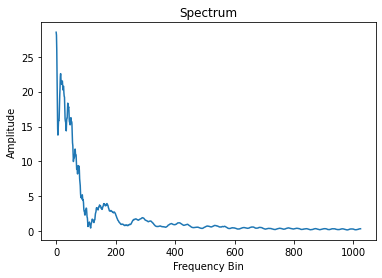

In [16]:
ECG,label = test_Dataset.__getitem__(0)

ft = np.abs(librosa.stft(ECG[1].numpy(), hop_length = 5000+1))
plt.plot(ft)
plt.title('Spectrum')
plt.xlabel('Frequency Bin')
plt.ylabel('Amplitude')

In [18]:
ft.shape

(1025, 1)

In [ ]:
testmodel = (Net.MLBFNet(True,res = True,se = True,Dropout_rate = 0.25)).to(DEVICE)  # type: ignore
# testmodel = (Models.resnet18(12,64,2)).to(DEVICE)
testmodel.load_state_dict(torch.load("./model/20221025_113645/parameter_EarlyStoping_0.pt"))

In [ ]:
# TEST_BATCH_SIZE = test_Dataset.npys.__len__()
test_dataloader = Data.DataLoader(dataset=test_Dataset, batch_size=512)

test_acc = []   
criterion = torch.nn.CrossEntropyLoss() 
possibility,y_true,y_pred,test_loss,test_acc, = eval_model_possibility(test_dataloader,criterion,testmodel,DEVICE) # 测试模型
print('loss =',test_loss,'acc =',test_acc)
print('f1_macro =',f1_score(y_true, y_pred, average='macro')) 

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
print("Confusion Matrix: ")
print(cm)

In [ ]:
possibility = np.array(possibility)

In [ ]:
import cleanlab
fake_label = cleanlab.filter.find_label_issues(y_true,possibility)

In [ ]:
for i in range(y_pred.__len__()):
    print('fake lable',fake_label[i])
    print('y_pred',y_pred[i])
    print('y_true',y_true[i])
    print(possibility[i])
    

In [13]:
torch.cuda.empty_cache()# 清空显卡cuda
# NET = [
#     Net.channels_branch_CNN(True,res = True,se = True,Dropout_rate = 0.25)
# ]
# NET = [Net.channels_branch_CNN(True,res = True,se = True,Dropout_rate = 0.25) ] # type: ignore
# NET = [relat_abs_Net.MLBFNet_GUR() ] # type: ignore
NET = [Net.ECGNet_GUR_single(True,res = True,se = True,Dropout_rate = 0.1) ] # type: ignore


In [14]:
input = torch.randn(1, 12,5000)
output = NET[0](input)

RuntimeError: input.size(-1) must be equal to input_size. Expected 192, got 256

In [4]:
print(output)

tensor([[0.3896, 0.6104]], grad_fn=<SoftmaxBackward0>)


### 读取csv测试集的结果,并绘制图像

In [4]:
data = select_dataset.splite_dataset('/workspace/data/Preprocess_HTN/data/',True)
test_list = data.__get_test_file_list__(shuffer=False,filter_department='外科')
ECG_root = '/workspace/data/Preprocess_HTN/data/ECG'
EcgChannles_num = 12
EcgLength_num = 5000
test_Dataset = ecg_get_data.ECG_Dataset(ECG_root,test_list,EcgChannles_num,EcgLength_num,position_encode=False)

	
 orginal   fliter department&age
  33342       8479   
	
 orginal   fliter duplicated
   509        423    
	
 orginal   fliter duplicated
   8479       7043   
	
       HTN  NHTN 
test   423   423 
npys:{%d} 846


In [49]:
answer1 = pd.read_csv('./20221111_034149_test.csv')
answer1.rename(columns={'pred':'pred1'},inplace=True) 
answer2 = pd.read_csv('./20221111_090319_test.csv')
answer2.rename(columns={'pred':'pred2'},inplace=True) 
answer3 = pd.read_csv('./20221111_144243_test.csv')
answer3.rename(columns={'pred':'pred3'},inplace=True) 
answer4 = pd.read_csv('./20221112_150151_test.csv')
answer4.rename(columns={'pred':'pred4'},inplace=True) 
answer5 = pd.read_csv('./20221112_025042_test.csv')
answer5.rename(columns={'pred':'pred5'},inplace=True) 
answer1 = pd.merge(answer1,answer2.loc[:,['file name','pred2']],how='outer',on='file name')
answer1 = pd.merge(answer1,answer3.loc[:,['file name','pred3']],how='outer',on='file name')
answer1 = pd.merge(answer1,answer4.loc[:,['file name','pred4']],how='outer',on='file name')
answer1 = pd.merge(answer1,answer5.loc[:,['file name','pred5']],how='outer',on='file name')

In [50]:
answer1

,Unnamed: 0,file name,true,pred1,pred2,pred3,pred4,pred5
0,0,21-1-1059_HTN.npy,1,0,0,0,0,0
1,1,21-1-105_HTN.npy,1,1,1,1,1,1
2,2,21-1-1191_HTN.npy,1,1,1,1,1,1
3,3,21-1-1303_HTN.npy,1,1,0,1,1,1
4,4,21-1-1305_HTN.npy,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...
841,841,21-1-2983_NHTN.npy,0,0,0,0,0,0
842,842,21-1-298_NHTN.npy,0,0,0,0,0,0
843,843,21-1-2997_NHTN.npy,0,0,0,0,0,0
844,844,21-1-3001_NHTN.npy,0,1,0,0,0,0


In [51]:
answer1.insert(loc=len(answer1.columns), column='ERR_Count', value=(abs(5*answer1['true'] -(answer1['pred1']+answer1['pred2']+answer1['pred3']+answer1['pred4']+answer1['pred5']))))

In [58]:
(answer1['ERR_Count']).value_counts()

0    576
1    100
5     64
2     44
4     42
3     20
Name: ERR_Count, dtype: int64

In [67]:
HTN_errs = answer1[(answer1['ERR_Count']>2)&(answer1['true'] == 1)]

In [68]:
HTN_errs

,Unnamed: 0,file name,true,pred1,pred2,pred3,pred4,pred5,ERR_Count
0,0,21-1-1059_HTN.npy,1,0,0,0,0,0,5
11,11,21-1-1489_HTN.npy,1,0,0,1,0,0,4
13,13,21-1-1775_HTN.npy,1,0,0,0,0,0,5
16,16,21-1-187_HTN.npy,1,0,0,0,0,0,5
18,18,21-1-2036_HTN.npy,1,0,0,1,0,1,3
...,...,...,...,...,...,...,...,...,...
390,390,21-8-2652_HTN.npy,1,0,0,0,0,0,5
394,394,21-8-2827_HTN.npy,1,0,0,0,0,0,5
397,397,21-8-3111_HTN.npy,1,1,0,0,0,0,4
403,403,21-8-4043_HTN.npy,1,0,1,0,0,0,4


In [69]:
HTN_errs['ERR_Count'].value_counts()

5    63
4    35
3    13
Name: ERR_Count, dtype: int64

In [86]:
csv_data = pd.DataFrame()
count = 0 
for index in tqdm((HTN_errs['Unnamed: 0']).tolist()):
    inf = (data.__read_info__(HTN_errs.loc[index,'file name'])).reset_index(drop=True)
    ECG,label = test_Dataset.__getitem__(index)
    file_name = inf['name'][0]+'_'+inf['gender'][0]+'_'+str(inf['years'][0])+'_'+inf['department'][0] +'_'+(inf['diagnose'][0]).replace('/','-')+'_'+inf['ID'][0] +'_'+inf['date'][0] 
    ecg_plot.plot(ECG*3500/1000, sample_rate = 500, title = file_name,row_height= 10,show_grid=True,show_separate_line=True)
    file_name = str(count)+'_'+str(HTN_errs.loc[index,'file name'])+'_'+file_name+'_'+str(HTN_errs.loc[index,'ERR_Count'])
    ecg_plot.save_as_png(file_name,'./ERR/HTN/',dpi = 100)
    csv_data = csv_data.append(inf)
    count = count + 1

100%|██████████| 111/111 [07:15<00:00,  3.93s/it]


In [91]:
csv_data = csv_data.reset_index(drop=True)

,num,name,years,gender,department,diagnose,ID,date,ECG_path
0,1059,晏亚齐,51,女,心血管内科病房,高血压1级,847548,2021-01-04 11:28:57,21-1-1059_HTN.npy
1,1489,杨希,35,女,心血管内科病房,高血压1级,846397,2021-01-06 15:57:22,21-1-1489_HTN.npy
2,1775,林景英,57,女,心血管内科病房,高血压2级,851034,2021-01-26 10:41:11,21-1-1775_HTN.npy
3,187,刘恭裕,58,男,肾内科病房,高血压,851114,2021-01-26 15:48:48,21-1-187_HTN.npy
4,2036,毛景坚,34,男,心血管内科病房,高血压3级,848051,2021-01-11 16:14:05,21-1-2036_HTN.npy
...,...,...,...,...,...,...,...,...,...
106,2652,苏宝崇,67,男,心血管内科病房,高血压,883055,2021-08-12 09:26:03,21-8-2652_HTN.npy
107,2827,蔡聪敏,72,男,心血管内科病房,高血压3级,729993,2021-08-20 18:26:11,21-8-2827_HTN.npy
108,3111,邵金亭,91,男,干部保健一科二区,高血压病1级（极高危）,565448,2021-08-16 15:30:59,21-8-3111_HTN.npy
109,4043,黄建敏,43,男,心血管内科病房,高血压,884164,2021-08-18 13:18:18,21-8-4043_HTN.npy


In [111]:
csv_data = pd.merge(csv_data,(HTN_errs.loc[:,['file name','ERR_Count']].reset_index(drop=True).rename(columns={'file name':'ECG_path'})),how='inner',on='ECG_path')
csv_data.to_csv('./ERR/HTN/高血压分错.csv')

In [112]:
NHTN_errs = answer1[(answer1['ERR_Count']>1)&(answer1['true'] == 0)]

In [113]:
NHTN_errs

,Unnamed: 0,file name,true,pred1,pred2,pred3,pred4,pred5,ERR_Count
424,424,21-1-1007_NHTN.npy,0,1,1,1,0,0,3
425,425,21-1-1013_NHTN.npy,0,0,0,1,1,0,2
445,445,21-1-109_NHTN.npy,0,0,1,1,0,0,2
455,455,21-1-1155_NHTN.npy,0,1,0,1,1,1,4
465,465,21-1-1246_NHTN.npy,0,0,1,1,1,1,4
470,470,21-1-1290_NHTN.npy,0,0,0,1,0,1,2
477,477,21-1-1309_NHTN.npy,0,1,1,1,0,1,4
479,479,21-1-1314_NHTN.npy,0,0,1,0,1,0,2
483,483,21-1-1326_NHTN.npy,0,0,0,1,0,1,2
485,485,21-1-1332_NHTN.npy,0,0,0,1,1,0,2


In [114]:
NHTN_errs['ERR_Count'].value_counts()

2    28
3     7
4     7
5     1
Name: ERR_Count, dtype: int64

In [115]:
csv_data = pd.DataFrame()
count = 0 
for index in tqdm((NHTN_errs['Unnamed: 0']).tolist()):
    inf = (data.__read_info__(NHTN_errs.loc[index,'file name'])).reset_index(drop=True)
    ECG,label = test_Dataset.__getitem__(index)
    file_name = inf['name'][0]+'_'+inf['gender'][0]+'_'+str(inf['years'][0])+'_'+inf['department'][0] +'_'+(inf['diagnose'][0]).replace('/','-')+'_'+inf['ID'][0] +'_'+inf['date'][0] 
    ecg_plot.plot(ECG*3500/1000, sample_rate = 500, title = file_name,row_height= 10,show_grid=True,show_separate_line=True)
    file_name = str(count)+'_'+str(NHTN_errs.loc[index,'file name'])+'_'+file_name+'_'+str(NHTN_errs.loc[index,'ERR_Count'])
    ecg_plot.save_as_png(file_name,'./ERR/NHTN/',dpi = 100)
    csv_data = csv_data.append(inf)
    count = count + 1
csv_data = pd.merge(csv_data.reset_index(drop=True),(NHTN_errs.loc[:,['file name','ERR_Count']].reset_index(drop=True).rename(columns={'file name':'ECG_path'})),how='inner',on='ECG_path')
csv_data.to_csv('./ERR/NHTN/非高血压分错.csv')

100%|██████████| 43/43 [02:47<00:00,  3.90s/it]


#### 正确

In [119]:
HTN_correct = answer1[((answer1['ERR_Count']<=2)&(answer1['true'] == 1))]

In [120]:
HTN_correct

,Unnamed: 0,file name,true,pred1,pred2,pred3,pred4,pred5,ERR_Count
1,1,21-1-105_HTN.npy,1,1,1,1,1,1,0
2,2,21-1-1191_HTN.npy,1,1,1,1,1,1,0
3,3,21-1-1303_HTN.npy,1,1,0,1,1,1,1
4,4,21-1-1305_HTN.npy,1,1,1,1,1,1,0
5,5,21-1-1311_HTN.npy,1,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...
417,417,21-8-98_HTN.npy,1,0,1,1,1,1,1
418,418,21-9-170_HTN.npy,1,1,1,1,1,1,0
419,419,21-9-286_HTN.npy,1,1,1,1,1,1,0
420,420,21-9-300_HTN.npy,1,1,1,1,1,1,0


In [121]:
HTN_correct['ERR_Count'].value_counts()

0    254
1     42
2     16
Name: ERR_Count, dtype: int64

In [122]:
csv_data = pd.DataFrame()
count = 0 
for index in tqdm((HTN_correct['Unnamed: 0']).tolist()):
    inf = (data.__read_info__(HTN_correct.loc[index,'file name'])).reset_index(drop=True)
    ECG,label = test_Dataset.__getitem__(index)
    file_name = inf['name'][0]+'_'+inf['gender'][0]+'_'+str(inf['years'][0])+'_'+inf['department'][0] +'_'+(inf['diagnose'][0]).replace('/','-')+'_'+inf['ID'][0] +'_'+inf['date'][0] 
    ecg_plot.plot(ECG*3500/1000, sample_rate = 500, title = file_name,row_height= 10,show_grid=True,show_separate_line=True)
    file_name = str(count)+'_'+str(HTN_correct.loc[index,'file name'])+'_'+file_name+'_'+str(HTN_correct.loc[index,'ERR_Count'])
    ecg_plot.save_as_png(file_name,'./Right/HTN/',dpi = 100)
    csv_data = csv_data.append(inf)
    count = count + 1

100%|██████████| 312/312 [20:06<00:00,  3.87s/it]


In [123]:
csv_data = csv_data.reset_index(drop=True)

In [124]:
csv_data = pd.merge(csv_data.reset_index(drop=True),(HTN_correct.loc[:,['file name','ERR_Count']].reset_index(drop=True).rename(columns={'file name':'ECG_path'})),how='inner',on='ECG_path')
csv_data.to_csv('./Right/HTN/高血压.csv')

In [125]:
NHTN_correct = answer1[((answer1['ERR_Count']<2)&(answer1['true'] == 0))]

In [126]:
NHTN_correct

,Unnamed: 0,file name,true,pred1,pred2,pred3,pred4,pred5,ERR_Count
423,423,21-1-1003_NHTN.npy,0,0,0,0,0,0,0
426,426,21-1-1019_NHTN.npy,0,0,0,0,0,0,0
427,427,21-1-1033_NHTN.npy,0,0,0,0,0,0,0
428,428,21-1-1035_NHTN.npy,0,0,0,0,0,0,0
429,429,21-1-103_NHTN.npy,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
841,841,21-1-2983_NHTN.npy,0,0,0,0,0,0,0
842,842,21-1-298_NHTN.npy,0,0,0,0,0,0,0
843,843,21-1-2997_NHTN.npy,0,0,0,0,0,0,0
844,844,21-1-3001_NHTN.npy,0,1,0,0,0,0,1


In [128]:
NHTN_correct['ERR_Count'].value_counts()

0    322
1     58
Name: ERR_Count, dtype: int64

In [129]:
csv_data = pd.DataFrame()
count = 0 
for index in tqdm((NHTN_correct['Unnamed: 0']).tolist()):
    inf = (data.__read_info__(NHTN_correct.loc[index,'file name'])).reset_index(drop=True)
    ECG,label = test_Dataset.__getitem__(index)
    file_name = inf['name'][0]+'_'+inf['gender'][0]+'_'+str(inf['years'][0])+'_'+inf['department'][0] +'_'+(inf['diagnose'][0]).replace('/','-')+'_'+inf['ID'][0] +'_'+inf['date'][0] 
    ecg_plot.plot(ECG*3500/1000, sample_rate = 500, title = file_name,row_height= 10,show_grid=True,show_separate_line=True)
    file_name = str(count)+'_'+str(NHTN_correct.loc[index,'file name'])+'_'+file_name+'_'+str(NHTN_correct.loc[index,'ERR_Count'])
    ecg_plot.save_as_png(file_name,'./Right/NHTN/',dpi = 100)
    csv_data = csv_data.append(inf)
    count = count + 1

 46%|████▌     | 175/380 [11:13<13:41,  4.01s/it]/opt/conda/lib/python3.7/site-packages/ecg_plot/ecg_plot.py:248: UserWarning: Glyph 57344 (\ue000) missing from current font.
  plt.savefig(path + file_name + '.png', dpi = dpi, bbox_inches=layout)
100%|██████████| 380/380 [24:10<00:00,  3.82s/it]


In [130]:
csv_data = csv_data.reset_index(drop=True)

In [131]:
csv_data = pd.merge(csv_data.reset_index(drop=True),(NHTN_correct.loc[:,['file name','ERR_Count']].reset_index(drop=True).rename(columns={'file name':'ECG_path'})),how='inner',on='ECG_path')
csv_data.to_csv('./Right/NHTN/非高血压.csv')